# Preparation

In [1]:
# %load_ext ipycache
import iminuit
# %load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

%load_ext rpy2.ipython

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
%%R
library(ggplot2)
library(ggpubr)

In [3]:
results = pd.DataFrame()

# Read patient data

In [5]:
data = pd.read_csv('data/C14 samples Erlangen 2019_20190830.csv')
data = data.groupby(['ID', 'tissue', 'labelling']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data['e14C'] = data['error_measurement']
datao = data.query('tissue == "Amygdala" and labelling=="NeuN+"')
data = datao.append(pd.Series({'ID':'P5new','tissue':'Amygdala','labelling':'NeuN+',
             'Dbirth':1973,'Dcoll':2017,'subject_age':44,'age':44,
            'd14C':(datao.loc[16,'d14C'] + datao.loc[14,'d14C'])/2,
            'e14C':(datao.loc[16,'e14C'] + datao.loc[14,'e14C'])/2,
            'error_measurement':(datao.loc[16,'e14C'] + datao.loc[14,'e14C'])/2},name=22))
exp_data = data

# Individual rates

In [6]:
import c14
import c14.models.amygdala
#take about 5 hours
ind_rates = []
index =[]
for ind,_ in exp_data.iterrows():
    row = data.loc[[ind]]
    m = c14.models.amygdala.A()
    edata = c14.exp_data(row)
    op = c14.optimize(m,edata,step_size=0.1)
    for i in  [0,-1,-2]:
        resa = sp.optimize.minimize(lambda x: op.Nloglike(x, op.model), [i],method='powell')
        resa['x'] = float(resa['x'])
        ind_rates.append(resa) 
    
    index.append(ind)
individual_rates_raw = pd.DataFrame(ind_rates,index=pd.MultiIndex.from_product([index,['a','b','c']],names=['index','ms']))

Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
/home/julian/pythonenv/c14/lib/python3.8/site-packages/scipy/optimize/optimize.py:2970: RuntimeWarning: invalid value encountered in subtract
  if (fx2 - fval) > delta:
/home/julian/pythonenv/c14/lib/python3.8/site-packages/scipy/optimize/optimize.py:2979: RuntimeWarning: invalid value encountered in subtract
  if 2.0 * (fx - fval) <= bnd:
/home/julian/pythonenv/c14/lib/python3.8/site-packages/scipy/optimize/optimize.py:2555: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logpar

In [7]:
individual_rates=[]
for i in individual_rates_raw.index.levels[0]:
    il = np.argmin(individual_rates_raw.loc[pd.IndexSlice[i,:]]['fun'])
    individual_rates.append(individual_rates_raw.loc[pd.IndexSlice[i,:]].iloc[il])
individual_rates = pd.DataFrame(individual_rates,index=individual_rates_raw.index.levels[0])

In [16]:
exp_data['individual_rate_SSE'] = 10**individual_rates['x']
exp_data

,ID,tissue,labelling,Dbirth,Dcoll,d14C,error_measurement,subject_age,age,e14C,individual_rate_SSE
0,ER2019_01,Amygdala,NeuN+,1932,2012,0.00540,0.009000,80,80,0.009000,0.001382
4,ER2019_02,Amygdala,NeuN+,1936,2012,-0.00130,0.010000,76,76,0.010000,0.000975
8,ER2019_03,Amygdala,NeuN+,1954,2017,-0.00330,0.006350,63,63,0.006350,0.001432
12,ER2019_04,Amygdala,NeuN+,1969,2017,0.45630,0.010900,48,48,0.010900,0.008090
14,ER2019_05,Amygdala,NeuN+,1973,2017,0.31090,0.008150,44,44,0.008150,0.015588
16,ER2019_06,Amygdala,NeuN+,1973,2017,0.33320,0.007300,44,44,0.007300,0.013004
22,P5new,Amygdala,NeuN+,1973,2017,0.32205,0.007725,44,44,0.007725,0.014267


<ipython-input-17-b1a8a24e0990>:6: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rc('text.latex', preamble=[


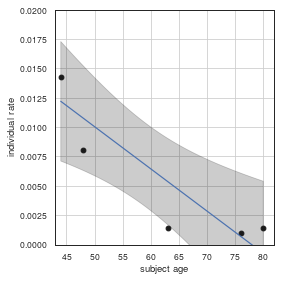

In [17]:
from matplotlib import rcParams,rc
fonts = 1
sns.set(context="paper",style='white',font_scale=fonts)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text.latex', preamble=[
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  )


rc('text', usetex=True)

plt.rcParams["axes.grid"] = True
fig=plt.figure(figsize=(4,4))

plt.fill_between(pg.x,pg.ymax,pg.ymin,color='black',alpha=0.2)
exp_dataA = exp_data.drop([16,14])
l,=plt.plot(exp_dataA.subject_age,exp_dataA.individual_rate_SSE,'ko')
plt.plot(pg.x,pg.y)


plt.xlabel('subject age')
plt.ylabel('individual rate')
plt.ylim(0,0.02)
plt.xlim(43,82)
plt.tight_layout()
# plt.legend(loc="upper left", bbox_to_anchor=(1.1, 1.1))
plt.savefig('../c14-a/A.pdf',dpi=600, bbox_inches='tight')
plt.savefig('../c14-a/A.png',dpi=600, bbox_inches='tight')

#plt.ylim(-0.01,0.02)
#plt.xlim(43,82)
#plt.tight_layout()
# plt.legend(loc="upper left", bbox_to_anchor=(1.1, 1.1))
#plt.savefig('../c14-a/A2.pdf',dpi=600, bbox_inches='tight')
#plt.savefig('../c14-a/A2.png',dpi=600, bbox_inches='tight')

<ipython-input-18-bf78723b3934>:6: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rc('text.latex', preamble=[


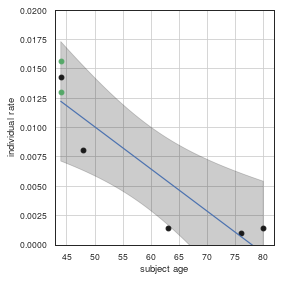

In [18]:
from matplotlib import rcParams,rc
fonts = 1
sns.set(context="paper",style='white',font_scale=fonts)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text.latex', preamble=[
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  )


rc('text', usetex=True)

plt.rcParams["axes.grid"] = True
fig=plt.figure(figsize=(4,4))

plt.fill_between(pg.x,pg.ymax,pg.ymin,color='black',alpha=0.2)
exp_dataA = exp_data.drop([16,14])
l,=plt.plot(exp_dataA.subject_age,exp_dataA.individual_rate_SSE,'ko')
exp_dataA = exp_data.loc[[16,14]]
l,=plt.plot(exp_dataA.subject_age,exp_dataA.individual_rate_SSE,'go')
plt.plot(pg.x,pg.y)


plt.xlabel('subject age')
plt.ylabel('individual rate')
plt.ylim(0,0.02)
plt.xlim(43,82)
plt.tight_layout()
# plt.legend(loc="upper left", bbox_to_anchor=(1.1, 1.1))
plt.savefig('../c14-a/A2.pdf',dpi=600, bbox_inches='tight')
plt.savefig('../c14-a/A2.png',dpi=600, bbox_inches='tight')

#plt.ylim(-0.01,0.02)
#plt.xlim(43,82)
#plt.tight_layout()
# plt.legend(loc="upper left", bbox_to_anchor=(1.1, 1.1))
#plt.savefig('../c14-a/A2.pdf',dpi=600, bbox_inches='tight')
#plt.savefig('../c14-a/A2.png',dpi=600, bbox_inches='tight')